# Imports

In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

---

# Carga de datos

In [3]:
auctions = pd.read_pickle("../../../../data/tp2/auctions_tp2_formateado.pkl")
clicks = pd.read_pickle("../../../../data/tp2/clicks_tp2_formateado.pkl")
events = pd.read_pickle("../../../../data/tp2/events_tp2_formateado.pkl")
installs = pd.read_pickle("../../../../data/tp2/clicks_tp2_formateado.pkl")

---

# Cargo dispositivos de la competencia

In [2]:
targets = pd.read_pickle("../../../../data/tp2/ref_hashes_target.pkl")

---

# Cargo los labels calculados hasta el momento

In [3]:
labels_v1 = pd.read_pickle("../../targets/targets_ventana_1_auctions.pkl")
labels_v2 = pd.read_pickle("../../targets/targets_ventana_2_auctions.pkl")
labels_v3 = pd.read_pickle("../../targets/targets_ventana_3_auctions.pkl")
labels_v4 = pd.read_pickle("../../targets/targets_ventana_4_auctions.pkl")
labels_v5 = pd.read_pickle("../../targets/targets_ventana_5_auctions.pkl")

# Observo que tan uniforme es el comportamiento de los dispositivos

/opt/anaconda/3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/anaconda/3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


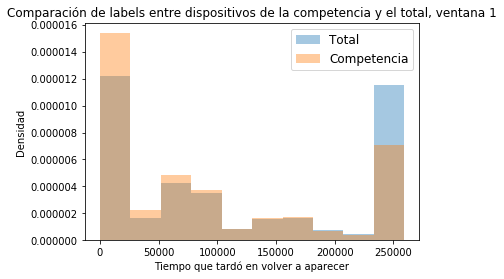

In [33]:
sns.distplot(labels_v1["target"],  kde=False, label='Total',norm_hist=True,bins=10)
sns.distplot(labels_v1.loc[labels_v1.index.isin(targets.index)]["target"],  kde=False, label='Competencia', norm_hist=True, bins=10)

plt.legend(prop={'size': 12})
plt.title('Comparación de labels entre dispositivos de la competencia y el total, ventana 1')
plt.xlabel('Tiempo que tardó en volver a aparecer')
plt.ylabel('Densidad');

In [ ]:
sns.distplot(labels_v1["target"],  kde=False, label='Total',norm_hist=True,bins=10)
sns.distplot(labels_v1.loc[labels_v1.index.isin(targets.index)]["target"],  kde=False, label='Competencia', norm_hist=True, bins=10)

plt.legend(prop={'size': 12})
plt.title('Comparación de labels entre dispositivos de la competencia y el total, ventana 2')
plt.xlabel('Tiempo que tardó en volver a aparecer')
plt.ylabel('Densidad');